In [25]:
import pandas as pd
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.ensemble import BaggingRegressor

import numba
import joblib

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as DataReader
import yfinance as yfin
yfin.pdr_override()

import talib

In [84]:
df = pd.read_pickle('df_merge.pkl')

# 特徴量作成
def make_feature(df):
    df = df.assign(
        next_c2o = lambda df: df['始値'].shift(-1)/df['終値']-1,
        c2o = lambda df: df.next_c2o.shift(1)-1,

        o2c = lambda df: df['終値']/df['始値']-1,
        
        dow_o2c = lambda df: df.Close.shift(1).astype(float)/df.Open.shift(1).astype(float)-1,

        pre_o2c = lambda df: df.o2c.shift(1),
        pre_c2o = lambda df: df['始値'].shift(1)/df['終値'].shift(2)-1,

        pre_o2c2 = lambda df: df.pre_o2c.shift(1),
        pre_c2o2 = lambda df: df.pre_c2o.shift(1),

        pre_o2c3 = lambda df: df.pre_o2c.shift(1),
        pre_c2o3 = lambda df: df.pre_c2o.shift(1),

        trend = lambda df: df['終値'].shift(1)/df['終値'].shift(70)-1,
        trend2 = lambda df: df['終値'].shift(1)/df['終値'].shift(100)-1,
        trend3 = lambda df: df['終値'].shift(1)/df['終値'].shift(200)-1,
        trend_diff = lambda df: df.trend-df.trend.shift(30),
        
        diff_pre_c = lambda df: df['終値'].shift(1)/df['Close_n225'].shift(1)-1,
        diff_o = lambda df: df['始値'].shift(1)/df['Open_n225'].shift(1)-1,
        
        rsi180 = lambda df: (talib.RSI(df['終値'], timeperiod=180).shift(1)-50)/100,
    )
    return df

df = make_feature(df)
df

,日付,始値,高値,安値,終値,5日平均,25日平均,75日平均,VWAP,出来高,...,pre_c2o2,pre_o2c3,pre_c2o3,trend,trend2,trend3,trend_diff,diff_pre_c,diff_o,rsi180
Date,,,,,,,,,,,,,,,,,,,,,
2001-07-13,20010713,12510,12550,12300,12330,--,--,--,--,151130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-07-16,20010716,12360,12380,12270,12320,--,--,--,--,79000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002036,0.007444,NaN
2001-07-17,20010717,12140,12180,12110,12130,--,--,--,--,42250,...,NaN,-0.014388,NaN,NaN,NaN,NaN,NaN,-0.001893,-0.003900,NaN
2001-07-18,20010718,12160,12160,11840,11860,--,--,--,--,128080,...,0.002433,-0.003236,0.002433,NaN,NaN,NaN,NaN,0.000118,-0.006178,NaN
2001-07-19,20010719,11880,11960,11850,11930,12114,--,--,--,489830,...,-0.014610,-0.000824,-0.014610,NaN,NaN,NaN,NaN,-0.002740,0.003184,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20211223,29560,29630,29490,29620,29317,29489,29919.8,29542.4066,28669,...,0.011783,0.004967,0.011783,-0.054662,0.034847,-0.034483,-0.114148,0.029332,0.030263,0.014968
2021-12-24,20211224,29660,29715,29625,29660,29375,29455.4,29911.26,29669.1542,15139,...,0.004772,-0.002714,0.004772,-0.049117,0.060888,-0.005039,-0.121825,0.028530,0.029857,0.017345
2021-12-27,20211227,29610,29645,29500,29525,29509,29410.4,29896.93,29560.6537,17324,...,0.005442,0.002030,0.005442,-0.055414,0.044734,-0.001347,-0.117408,0.030484,0.028574,0.017777


In [104]:
# 特徴量リスト
feature1 = ['pre_o2c', 'pre_c2o', 'trend', 'dow_o2c', 'diff_pre_c', 'rsi180']
feature2 = ['c2o', 'pre_o2c', 'trend', 'trend2', 'rsi180']

C:\Users\sadan\anaconda3\lib\site-packages\numpy\lib\function_base.py:2246: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


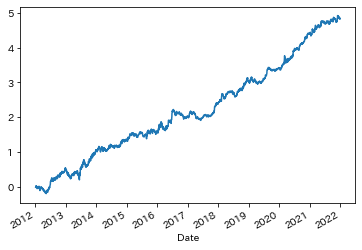

In [340]:
# Open 2 Close
model_c2o = Ridge(alpha=0.1)
# model_o2c = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
X = df[feature1].fillna(0)
y = df.o2c
pred = y.copy()
pred.loc[:] = np.nan

for year in range(2005,2022,1):
    target = (X.index.year == year)
    train = (X.index.year < year)&(X.index.year > year-15)

    model_c2o.fit(X.loc[train], y.loc[train])
    # joblib.dump(model_o2c, 'model_o2c.xz', compress=True)
    # model_o2c = joblib.load('model_o2c.xz')

    pred.loc[target] = model_c2o.predict(X.loc[target])

# pred = model_o2c.predict(X)
df['pred1'] = pred

losscut = 1.007
takeprofit = 1.03
df = df.assign(
    exec1 = lambda df: ((df['終値'].shift(1)/1.2<df['始値'])&(df.pred1<0))|((df['終値'].shift(1)*1.2>df['始値'])&(df.pred1>0)),
    rate_sl = lambda df: np.vectorize(lambda op, hi, lo, cl, side: (cl/op-1) if ((lo>(op/losscut))&(side>0))|((hi<(op*losscut))&(side<0)) 
                                   else (1/(losscut)-1)*side)(df['始値'], df['高値'], df['安値'], df['終値'], np.sign(df['pred1'])),
    is_sl = lambda df: np.vectorize(lambda op, hi, lo, cl, side: False if ((lo>(op/losscut))&(side>0))|((hi<(op*losscut))&(side<0)) 
                                   else True)(df['始値'], df['高値'], df['安値'], df['終値'], np.sign(df['pred1'])),
    rate_tp = lambda df: np.vectorize(lambda rate_sl, op, hi, lo, cl, side, is_sl: rate_sl if is_sl|(((hi<(op*takeprofit))&(side>0))|((lo>(op/takeprofit))&(side<0))) 
                                   else (takeprofit-1)*side)(df['rate_sl'], df['始値'], df['高値'], df['安値'], df['終値'], np.sign(df['pred1']), df['is_sl']),
    rate1 = lambda df: (df.rate_tp * df.pred1.apply(lambda x: 1 if x>0.000 else -1 if  x<-0.000 else 0)).apply(lambda x: 0 if x==0 else x-0.04/365) * df.exec1 * 3 + 1,
)

(df[df.index.year>2011].rate1-1).cumsum().plot()
plt.show()

2005


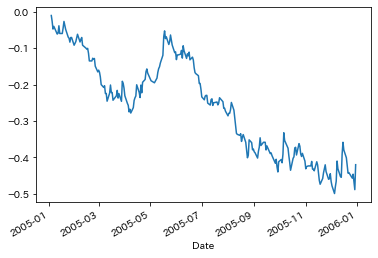

2006


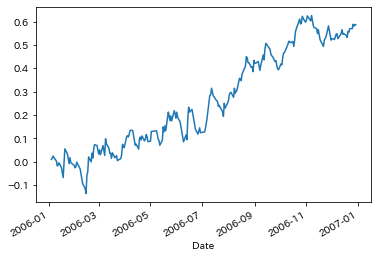

2007


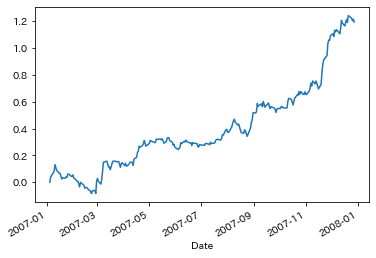

2008


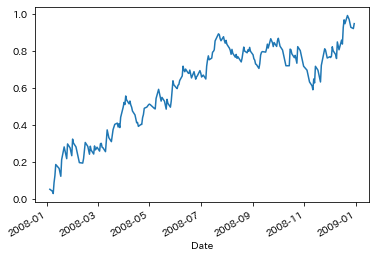

2009


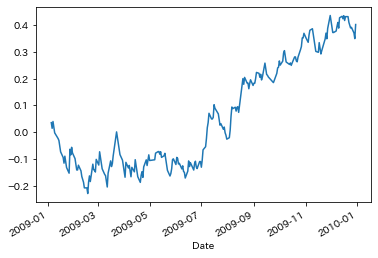

2010


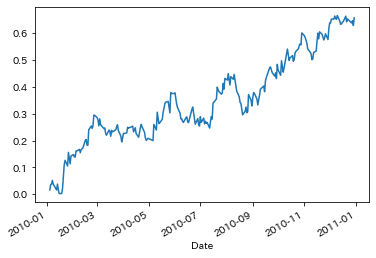

2011


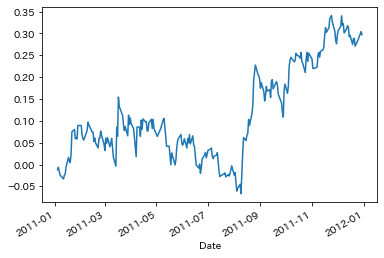

2012


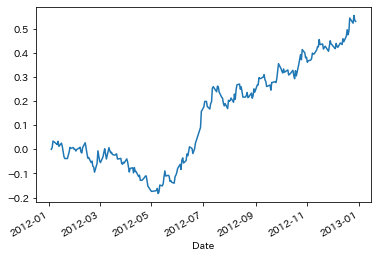

2013


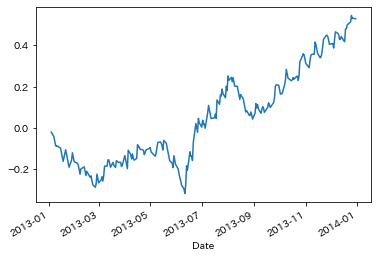

2014


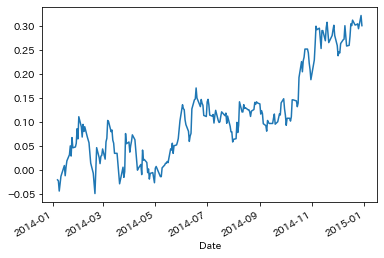

2015


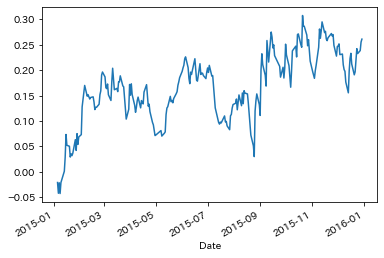

2016


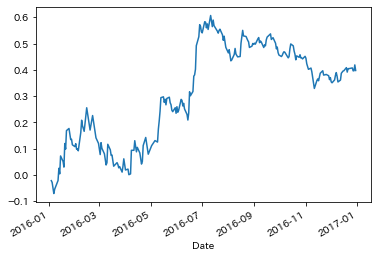

2017


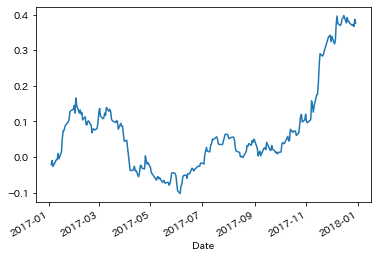

2018


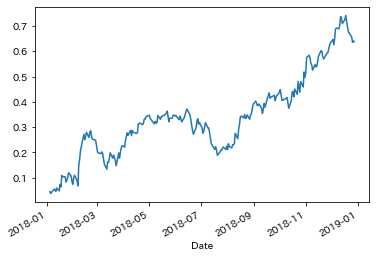

2019


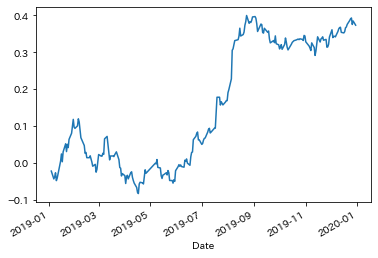

2020


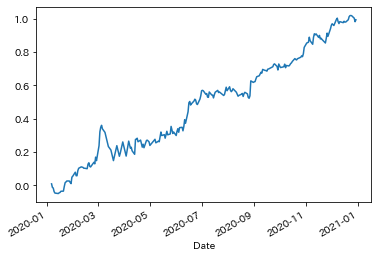

2021


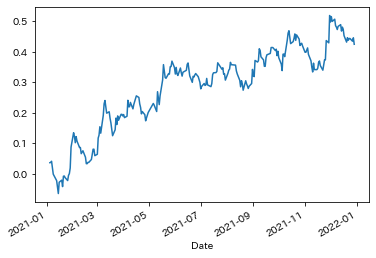

In [341]:
for y in range(2005, 2022, 1):
    print(y)
    (df[df.index.year==y].rate1-1).cumsum().plot()
    plt.show()

<AxesSubplot:>

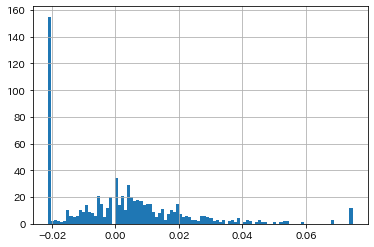

In [337]:
(df[df.index.year>=2019].rate1-1).hist(bins=100)

In [ ]:
# Close 2 Open
from sklearn.linear_model import ElasticNet
model_o2c = Ridge(alpha=0.1)
# model_o2c = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
X = df[feature1].fillna(0)
y = df.o2c
pred = y.copy()
pred.loc[:] = np.nan

for year in range(2009,2022,1):
    target = (X.index.year == year)
    train = (X.index.year < year)&(X.index.year > year-15)

    model_o2c.fit(X.loc[train], y.loc[train])
    joblib.dump(model_o2c, 'model_o2c.xz', compress=True)
    model_o2c = joblib.load('model_o2c.xz')

    pred.loc[target] = model_o2c.predict(X.loc[target])


df['pred1'] = pred

df = df.assign(
    exec1 = lambda df: ((df['終値'].shift(1)/1.005<df['始値'])&(df.pred1<0))|((df['終値'].shift(1)*1.005>df['始値'])&(df.pred1>0)),
    rate1 = lambda df: (df.o2c * df.pred1.apply(lambda x: 1 if x>0.000 else -1 if  x<-0.000 else 0)).apply(lambda x: 0 if x==0 else x-0.02/365) * 3 * df.exec1+1,
)

(df[df.index.year>2011].rate1-1).cumsum().plot()
# plt.yscale('log')
plt.show()

In [87]:
import tensorflow as tf 
import numpy as np 
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.layers import RNN, SimpleRNN, SimpleRNNCell, LSTMCell, Activation,  Input, Dense, Dropout, LSTM
from tensorflow.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.keras import initializers
from tensorflow.keras import  regularizers

Model: "functional_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(1, 1, 5)]               0         
_________________________________________________________________
rnn_32 (RNN)                 (1, 1, 5)                 220       
_________________________________________________________________
rnn_33 (RNN)                 (1, 1, 5)                 220       
_________________________________________________________________
rnn_34 (RNN)                 (1, 5)                    220       
_________________________________________________________________
dense_19 (Dense)             (1, 1)                    5         
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
2507/2507 [==============================] - 3s 1ms/step - loss: 1.3117e-04 - val_loss: 8.3534e-05


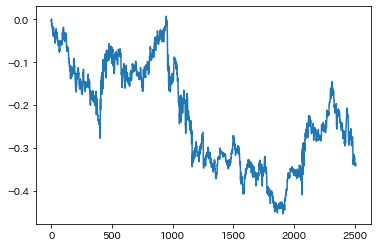

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2934e-04 - val_loss: 8.1791e-05


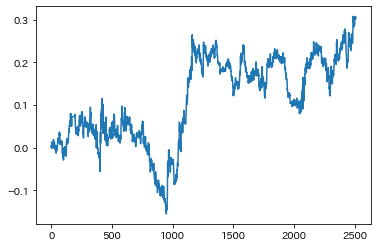

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2833e-04 - val_loss: 8.1750e-05


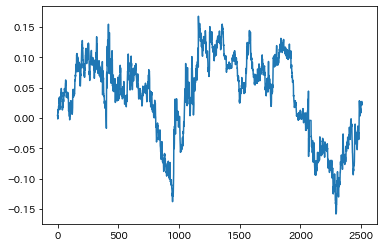

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2862e-04 - val_loss: 8.1145e-05


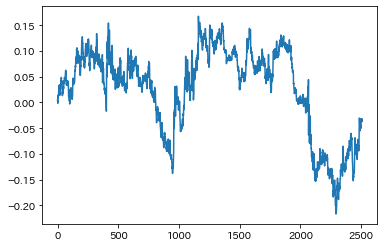

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2832e-04 - val_loss: 8.1143e-05


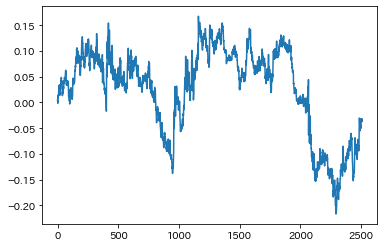

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2797e-04 - val_loss: 8.1433e-05


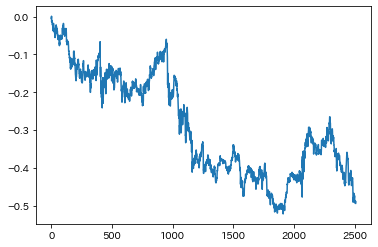

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2821e-04 - val_loss: 8.1158e-05


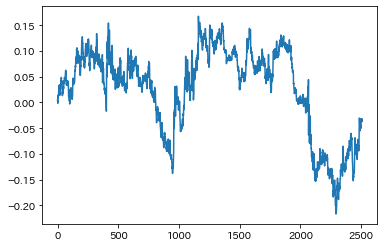

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2820e-04 - val_loss: 8.1322e-05


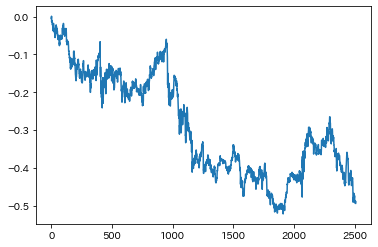

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2809e-04 - val_loss: 8.1134e-05


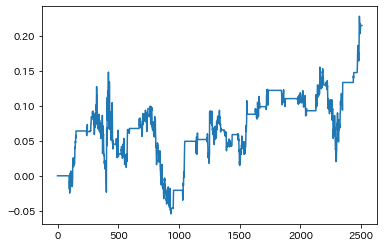

2507/2507 [==============================] - 3s 1ms/step - loss: 1.2812e-04 - val_loss: 8.1150e-05


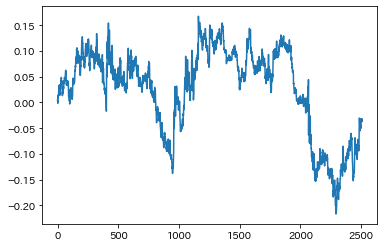

In [94]:
X_train = X.iloc[:len(X)//2].values
X_test= X.iloc[len(X)//2:].values
y_train = y.iloc[:len(y)//2].values
y_test = y.iloc[len(y)//2:].values

inputs = Input(batch_shape=(1, 1, X_train.shape[1]))
cell = LSTMCell(X_train.shape[1], activation='tanh', use_bias=True)
hiddens = RNN(cell, input_shape=(None, X_train.shape[1]), return_sequences=True, stateful=True)(inputs)
hiddens = RNN(cell, input_shape=(None, X_train.shape[1]), return_sequences=True, stateful=True)(hiddens)
hiddens = RNN(cell, input_shape=(None, X_train.shape[1]), return_sequences=False, stateful=True)(hiddens)
outputs = Dense(1, use_bias=False)(hiddens)

model = Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['binary_accuracy', metrics.AUC()])
model.compile(optimizer=RMSprop(), loss='mean_squared_error')
model.summary()

# es_cb = EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')
for _ in range(10):
    model.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1]), y_train, epochs=1, verbose=1, 
            validation_data=(X_test.reshape(X_test.shape[0],1,X_test.shape[1]), y_test), batch_size=1)
    pred = model.predict(X_test.reshape(X_test.shape[0],1,X_test.shape[1]), batch_size=1)
    model.reset_states()
    plt.plot((y_test * pd.Series(pred.reshape(-1)).apply(lambda x: 1 if x>0.0001 else -1 if  x<-0.0001 else 0)).apply(lambda x: 0 if x==0 else x-0.04/365).cumsum())
    plt.show()